In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.linalg import svd, eig
from scipy.integrate import solve_ivp
from scipy.fft import fft, ifft, fftshift
from mat73 import loadmat
from sklearn.linear_model import LinearRegression

# SINDy
from collections import Counter
from math import factorial
from itertools import permutations, combinations

In [2]:
class dmd:
    def __init__(self):
        self.is_fit = False
        self.lam = None # DMD eigenvalues
        self.phi = None # DMD modes
        self.ur = None # Truncated left singular vectors
        self.wa_inv = None # Matrix used to get init condition (7.29f in DDSE)

    def fit(self, x_full, r, mode='normal'):
        '''
        Get DMD evals and evecs.

        Args:
            - x_full: Data matrix (space x time) 
            - r: Desired rank / last singular value selected
            - mode: 'rand' for randomized svd, 'normal' for deterministic
        '''

        # Time shift data
        x = x_full[:,:-1]
        x_prime = x_full[:,1:]

        d, t = x_prime.shape # Get dimensions
        
        if mode == 'normal':
            u, s, vt = svd(x)
        elif mode == 'rand':
            u, s, vt = rand_svd(x, r)

        tmp = np.zeros((d,t))
        np.fill_diagonal(tmp, s)
        s = tmp # Make s a (d x t) matrix
        v = vt.T

        # Truncate matrices to rank r
        self.ur = u[:,:r]
        sr = s[:r,:r] # Singular values
        vr = v[:,:r]

        sr_inv = np.linalg.inv(sr)
        a_squig = self.ur.T @ x_prime @ vr @ sr_inv # Low dimensional dynamics matrix
        self.lam, w = eig(a_squig)
        self.lam = np.diag(self.lam)

        self.phi = x_prime @ vr @ sr_inv @ w
        self.wa_inv = np.linalg.inv(w @ self.lam)

        self.is_fit = True

    def predict(self, x0, k):
        '''
        Predict system dynamics k steps with DMD model.

        Args:
            - x0: Initial condition (space, 1)
            - k: Number of steps to forecast
        Returns:
            - x_hat: Prediction
        '''

        if not self.is_fit:
            raise("Model fit model before predicting.")

        x0_squig = self.ur.T @ x0
        b = self.wa_inv @ x0_squig

        x_hat = [x0] + [self.phi @ (self.lam**i) @ b for i in range(1,k+1)]

        return np.real(np.hstack(x_hat))

def lotka_volterra(t, u, b, p, d, r):
    u_dot = np.array([(b - p * u[1]) * u[0], 
                        (r * u[0] - d) * u[1]])
    return u_dot

def augment_delay(x, tau_hare, tau_lynx):
    '''
    Augment data matrix with delayed data.
    '''
    tau_diff = abs(tau_hare - tau_lynx)
    adv_hare = x[0,tau_hare:].reshape(1, -1)
    adv_lynx = x[1,tau_lynx:].reshape(1, -1)

    if tau_hare > tau_lynx:
        x_aug = x[:,:-tau_hare]
        x_aug = np.vstack((x_aug, adv_hare, adv_lynx[:,:-tau_diff]))
    elif tau_hare < tau_lynx:
        x_aug = x[:,:-tau_lynx]
        x_aug = np.vstack((x_aug, adv_hare[:,:-tau_diff], adv_lynx))
    else:
        x_aug = x[:,:-tau_lynx]
        x_aug = np.vstack((x_aug, adv_hare, adv_lynx))

    return x_aug

def get_forms(n, max_exp):
    '''
    Returns forms of polynomial terms of
    order n involving any exponents from [1, max_exp].
    Returns as a list of lists. Each sub-list contains
    the exponents of the term involved. For example:
    [3, 2, 1] => (a^3)*(b^2)*(c) for arbitrary a, b, c.
    '''
    forms = []
    rem = n - max_exp

    if rem >= 0:
        for exp in range(max_exp, 1, -1):
            mults = rem // exp

            for mult in range(mults, 0, -1):
                more_ones = rem - (mult * exp)
                forms.append([max_exp] + ([exp] * mult) + [1] * more_ones)

        forms.append([max_exp] + ([1] * rem))

    return forms


def get_count(form, d):
    '''
    Counts the number of polynomial terms of specified form
    constructable from d distinct variables.
    '''
    repeat_dict = dict(Counter(form))
    ith_repeat_count = []
    total_non_repeats = 0
    for _, v in repeat_dict.items():
        if v > 1:
            ith_repeat_count.append(v)
        else:
            total_non_repeats += 1

    count_denominator = factorial(d - total_non_repeats - sum(ith_repeat_count))
    for elt in ith_repeat_count:
        count_denominator *= factorial(elt)

    return factorial(d) / count_denominator

def append_combos(perm, i, shrinking_vars, ith_repeat_count):
    '''
    Recursive function appends combinations of variables of 
    repeated exponent degree.
    '''
    this_shrinking_vars = shrinking_vars
    combos = list(combinations(this_shrinking_vars, ith_repeat_count[i]))
    
    if i == len(ith_repeat_count) - 1:
        return [perm + list(combo) for combo in combos]

    else:
        terms = []
        for combo in combos:
            
            reduce_mask = np.ones(shape=this_shrinking_vars.shape, dtype=bool)
            for var in combo:
                reduce_mask *= (this_shrinking_vars != var)
            
            shrinking_vars = this_shrinking_vars[reduce_mask]
            
            addendum = append_combos(perm + list(combo), i+1, shrinking_vars, ith_repeat_count)
            terms = terms + addendum
        
        return terms

def get_terms(form, vars):
    '''
    Generates all possible terms of specified form
    from array of variables, vars.
    '''
    repeat_dict = dict(Counter(form))
    ith_repeat_count = []
    total_non_repeats = 0
    for _, v in repeat_dict.items():
        if v > 1:
            ith_repeat_count.append(v)
        else:
            total_non_repeats += 1

    terms = []
    for perm in permutations(vars, total_non_repeats):
        perm = list(perm)
        if total_non_repeats > 0:
            nr_mask = np.ones(shape=vars.shape, dtype=bool)
            for j in range(total_non_repeats):
                nr_mask *= (vars != perm[j])

            shrinking_vars = vars[nr_mask]
        else:
            shrinking_vars = vars

        if len(ith_repeat_count) > 0:
            terms = terms + append_combos(perm, 0, shrinking_vars, ith_repeat_count)
        else:
            terms.append(perm)

    return terms
            
def make_lib(x, d, n, extras=None):
    '''
    Generate library of augmented data up to 
    polynomial order, n, for system of dimension, d,
    from input data, x (space, time). May pass an iterable
    of extra functions to tack onto the end.

    Returns:
        - theta: Matrix of library fcns
        - lib_fcn_ids: List of tuples (form, term)
        starting at the first non-constant lib_fcn
    '''
    vars = np.arange(d)
    t = x.shape[1]
    theta = [np.ones(shape=(t, 1))]
    lib_fcn_ids = []

    for n in np.arange(1, n + 1):
        for max_exp in range(1, n + 1):
            forms = get_forms(n, max_exp)
            for form in forms:
                terms = get_terms(form, vars)
                form = np.array(form).reshape(-1,1)

                for term in terms:
                    term = np.array(term).reshape(1,-1)
                    lib_fcn = np.prod(np.power(x[term,:].reshape(-1,t), form), axis=0)
                    theta.append(lib_fcn.reshape(-1,1))
                    lib_fcn_ids.append((form.reshape(-1,), term.reshape(-1,)))

    if extras is not None:
        for fcn in extras:
            theta.append(fcn(x).T)

    theta = np.hstack(theta)
    return theta, lib_fcn_ids

def stls(theta, dxdt, lam, d):
    '''
    Sequentially thresholded least squares
    to do sparse regression.

    Args:
        - theta: Library of augmented data (time, # of lib fcns)
        - dxdt: LHS derivatives (time, dimension of system)
        - lam: Sparsity knob
        - d: Dimension of system
    Returns:
        - xi: Coefficients matrix (# of lib fcns, d)
    '''

    xi = np.linalg.pinv(theta) @ dxdt # First guess, least squares

    # Iteratively zero-out smallest coefs and re-regress to make sparse
    for i in range(10):
        small_idxs = abs(xi) < lam
        xi[small_idxs] = 0

        for j in range(d):
            big_idxs = ~small_idxs[:,j]
            xi[big_idxs, j] = np.linalg.pinv(theta[:,big_idxs]) @ dxdt[:,j]

    return xi

def write_eqns(xi, lib_fcn_ids, var_names):
    '''
    Write out symbolic equations from SINDy.
    '''
    eqns = []
    for i in range(xi.shape[1]):
        
        eqn = f"\dot({var_names[i]}) = "
        for j in range(xi.shape[0]):
            if j == 0:
                eqn += f"{xi[j,i]:.2f} "
            else:
                form, term = lib_fcn_ids[j - 1]
                lib_fcn = [f"({var_names[term[k]]}^{form[k]})" for k in range(form.shape[0])]
                lib_fcn = ''.join(lib_fcn)

                if xi[j,i] > 0:
                    eqn += f"+ {xi[j,i]:.2f}{lib_fcn} "
                elif xi[j,i] < 0:
                    eqn += f"- {abs(xi[j,i]):.2f}{lib_fcn} "
        
        eqns.append(eqn)

    return eqns

In [3]:
# Load data

data_set = 'animals' # Which dataset: 'animals' or 'circle'
theta = np.pi / 12 # Rotation angle for circle data
k = 30 # Number of rotations

if data_set == 'circle':
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    lam, w = eig(rot)
    lam = np.diag(lam)
    w_inv = np.linalg.inv(w)

    x0 = np.array([[1],[0]])
    x = [x0]
    for i in range(1,k+1):
        x.append(w @ (lam**i) @ w_inv @ x0)

    x = np.real(np.hstack(x))
    t = np.arange(k)
elif data_set == 'animals':
    animals = np.loadtxt('canadian_lynx_snowshoe_hare_1845_1903.csv', delimiter=',')
    t = animals[:,0]
    x = animals[:,1:].T

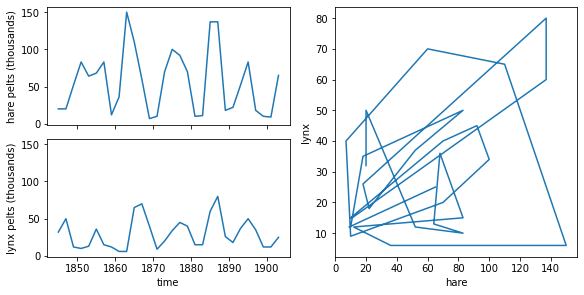

In [71]:
# Plot data

fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharey=ax1, sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:,1])

if data_set == 'animals':
    ax1.plot(t, x[0,:])
    ax2.plot(t, x[1,:])
elif data_set == 'circle':
    ax1.plot(x[0,:])
    ax2.plot(x[1,:])

ax3.plot(x[0,:], x[1,:])

ax2.set_xlabel("time")
ax1.set_ylabel('hare pelts (thousands)')
ax2.set_ylabel('lynx pelts (thousands)')
ax3.set_xlabel('hare')
ax3.set_ylabel('lynx')

plt.show()

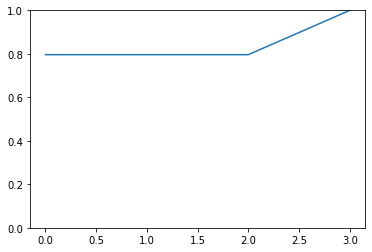

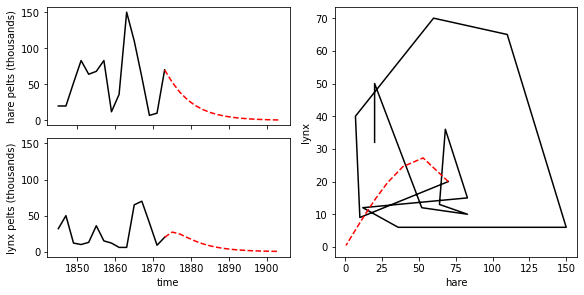

In [79]:
d, t_range = x.shape
start = 14
k = t_range - (start + 1)
x0 = x[:,start].reshape(d, 1)

# PLot singular values
u, s, vt = svd(x)
cum_energy = np.cumsum(np.diag(s) / s.sum())
plt.plot(cum_energy)
plt.ylim(0,1)
plt.show()

# DMD
dmd_model = dmd()
dmd_model.fit(x, d)
x_hat = dmd_model.predict(x0, k)

# Plot prediction
fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharey=ax1, sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:,1])

if data_set == 'animals':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')
elif data_set == 'circle':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')

ax3.plot(x[0,:start+1], x[1,:start+1], 'k-')
ax3.plot(x_hat[0,:], x_hat[1,:], 'r--')

ax2.set_xlabel("time")
ax1.set_ylabel('hare pelts (thousands)')
ax2.set_ylabel('lynx pelts (thousands)')
ax3.set_xlabel('hare')
ax3.set_ylabel('lynx')

plt.show()


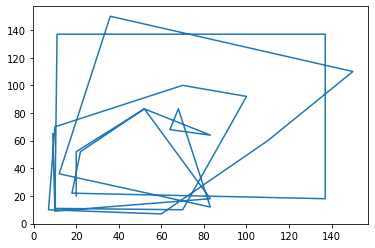

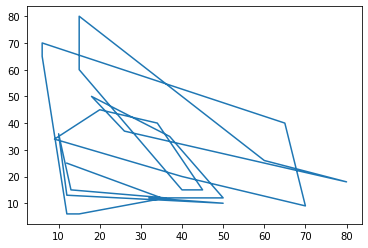

In [35]:
# Playing around w delay coordinates
tau = 1
d, n_timesteps = x.shape
hare = x[0,:n_timesteps-tau]
hare_tau = x[0, tau:]
plt.plot(hare, hare_tau)
plt.show()

tau = 2
d, _ = x.shape
lynx = x[1,:n_timesteps-tau]
lynx_tau = x[1, tau:]
plt.plot(lynx, lynx_tau)
plt.show()

In [82]:
# Augment data matrix for delay DMD

tau_hare = 1
tau_lynx = 2
x_aug = augment_delay(x, tau_hare, tau_lynx)


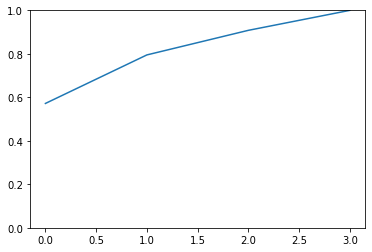

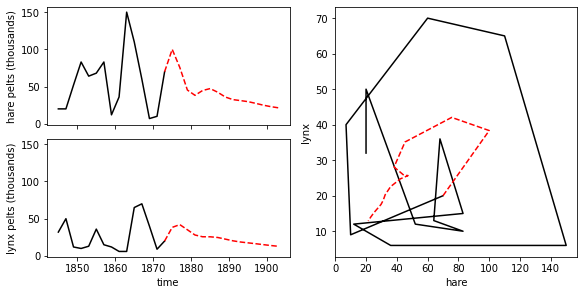

In [83]:

d = x_aug.shape[0]
k = 15
start = 14
x0 = x_aug[:,start].reshape(d, 1)

# Plot singular values of data
u, s, vt = svd(x_aug)
cum_energy = np.cumsum(s / s.sum())
plt.plot(cum_energy)
plt.ylim(0,1)
plt.show()

# DMD
dmd_model = dmd()
dmd_model.fit(x_aug, d)
x_hat = dmd_model.predict(x0, k)

# Plot prediction
fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharey=ax1, sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:,1])

if data_set == 'animals':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')
elif data_set == 'circle':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')

ax3.plot(x[0,:start+1], x[1,:start+1], 'k-')
ax3.plot(x_hat[0,:], x_hat[1,:], 'r--')

ax2.set_xlabel("time")
ax1.set_ylabel('hare pelts (thousands)')
ax2.set_ylabel('lynx pelts (thousands)')
ax3.set_xlabel('hare')
ax3.set_ylabel('lynx')

plt.show()

In [7]:
# Fit Lotka-Volterra model - linear regression, non-negative coefficients

# Augment data matrix with interaction term
xy = np.reshape(x[0,:] * x[1,:], (1,-1))
x_lv = np.concatenate((x, xy), axis=0)[:,:] # Take off last point to match derivatives length

# Calculate derivatives

# Spectral derivative
n = len(t)
kappa = 2 * np.pi * np.arange(-n/2, n/2) / n
derivatives = []
for i in range(2):
    fhat = fft(x[i,:])
    dfhat = 1j * fftshift(kappa) * fhat
    df = np.real(ifft(dfhat))
    derivatives.append(df)

# # Finite steps, midpoint
# derivatives = []
# for i in range(2):
#     df = (x[i,2:] - x[i,:-2]) / 4
#     derivatives.append(df)

# x_lv = x_l

# # Finite steps, step right
# derivatives = []
# for i in range(2):
#     df = (x[i,1:] - x[i,:-1]) / 2
#     derivatives.append(df)

# x_lv = x_lv[:,:-1]

derivatives = np.vstack(derivatives)

params = []
for i in range(2):
    # Adjust data to match signs of lotka-volterra
    auto = (-1)**i
    interact = auto * -1
    
    reg = LinearRegression(positive=True) # Constrain coefs to be non-negative
    this_x = np.vstack((x_lv[i,:] * auto, x_lv[2,:] * interact)).T
    reg.fit(this_x, derivatives[i])
    params.append(reg.coef_)

params = np.hstack(params)
print(params)

[0.52498398 0.01139168 0.66845208 0.0061114 ]


0 The solver successfully reached the end of the integration interval.


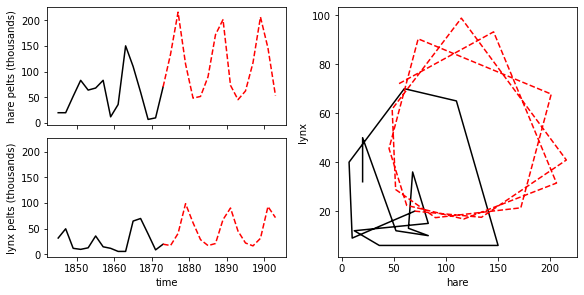

In [8]:
# Simulate fitted Lotka-Volterra model
start = 14
t_span = (t[start], t[-1])
t_eval = t[start:]
u0 = x[:,start]

sol = solve_ivp(lotka_volterra, t_span, u0, t_eval=t_eval, args=params)
print(sol.status, sol.message)
x_hat = sol.y


# Plot prediction
fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharey=ax1, sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:,1])

if data_set == 'animals':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')
elif data_set == 'circle':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')

ax3.plot(x[0,:start+1], x[1,:start+1], 'k-')
ax3.plot(x_hat[0,:], x_hat[1,:], 'r--')

ax2.set_xlabel("time")
ax1.set_ylabel('hare pelts (thousands)')
ax2.set_ylabel('lynx pelts (thousands)')
ax3.set_xlabel('hare')
ax3.set_ylabel('lynx')

plt.show()

In [91]:
# Fit nonlinear model with SINDy

d = 2 # Dim of system
n = 2 # Highest order polynomial to include

theta, lib_fcn_ids = make_lib(x, d, n)
xi = stls(theta, derivatives.T, lam=0.03, d=d)

var_names = ['x', 'y']
eqns = write_eqns(xi, lib_fcn_ids, var_names)
for eq in eqns:
    print(eq)

\dot(x) = 23.11 + 0.26(x^1) - 1.25(y^1) 
\dot(y) = -8.29 + 0.29(x^1) - 0.26(y^1) 


0 The solver successfully reached the end of the integration interval.


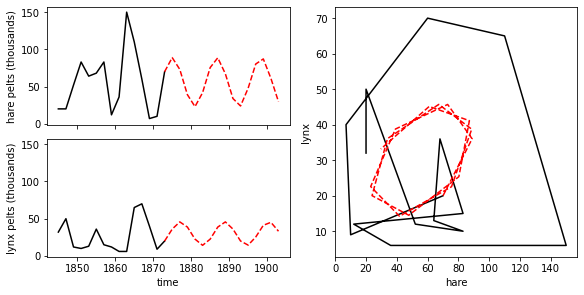

In [64]:
# Simulate best-fit nonlinear model from SINDy
def best_fit_nl_model(t, u, a, d, b, e, c, f):
    u_dot = np.array([a + b * u[0] + c * u[1], 
                        d + e * u[0] + f * u[1]])
    return u_dot

start = 14
t_span = (t[start], t[-1])
t_eval = t[start:]
u0 = x[:,start]
params = xi[abs(xi) > 0]

sol = solve_ivp(best_fit_nl_model, t_span, u0, t_eval=t_eval, args=params)
print(sol.status, sol.message)
x_hat = sol.y


# Plot prediction
fig = plt.figure(constrained_layout=True, figsize=(8,4))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharey=ax1, sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = fig.add_subplot(gs[:,1])

if data_set == 'animals':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')
elif data_set == 'circle':
    ax1.plot(t[:start+1], x[0,:start+1], 'k-')
    ax2.plot(t[:start+1], x[1,:start+1], 'k-')
    ax1.plot(t[start:], x_hat[0,:], 'r--')
    ax2.plot(t[start:], x_hat[1,:], 'r--')

ax3.plot(x[0,:start+1], x[1,:start+1], 'k-')
ax3.plot(x_hat[0,:], x_hat[1,:], 'r--')

ax2.set_xlabel("time")
ax1.set_ylabel('hare pelts (thousands)')
ax2.set_ylabel('lynx pelts (thousands)')
ax3.set_xlabel('hare')
ax3.set_ylabel('lynx')

plt.show()

In [134]:
# Get estimation from four models to compute KL divergence

d, t_range = x.shape
x0 = x[:,0].reshape(d,1)
u0 = x0.reshape(-1) # For scipy integrator
t_span = (t[0], t[-1]) # For scipy integrator
k = t_range - 1

# Compute derivatives
n = len(t)
kappa = 2 * np.pi * np.arange(-n/2, n/2) / n

derivatives = []
for i in range(2):
    fhat = fft(x[i,:])
    dfhat = 1j * fftshift(kappa) * fhat
    df = np.real(ifft(dfhat)) # Spectral derivative
    derivatives.append(df)

derivatives = np.vstack(derivatives)

# DMD model
dmd_model = dmd()
dmd_model.fit(x, d)
x_hat_dmd = dmd_model.predict(x0, k)

# DMD delay model
tau_hare = 1
tau_lynx = 2
x_aug = augment_delay(x, tau_hare, tau_lynx)
d_aug = x_aug.shape[0]
dmd_delay_model = dmd()
dmd_delay_model.fit(x_aug, d_aug)
x_hat_delay = dmd_model.predict(x0, k)

# Lotka-Volterra
xy = np.reshape(x[0,:] * x[1,:], (1,-1))
x_lv = np.concatenate((x, xy), axis=0)

# Fit
params = []
for i in range(2):
    # Adjust data to match signs of lotka-volterra
    auto = (-1)**i
    interact = auto * -1
    
    reg = LinearRegression(positive=True) # Constrain coefs to be non-negative
    this_x = np.vstack((x_lv[i,:] * auto, x_lv[2,:] * interact)).T
    reg.fit(this_x, derivatives[i])
    params.append(reg.coef_)

params_lv = np.hstack(params)


sol = solve_ivp(lotka_volterra, t_span, u0, t_eval=t, args=params_lv)
x_hat_lv = sol.y

# SINDy
n = 2 # Highest order polynomial to include

theta, lib_fcn_ids = make_lib(x, d, n)
xi = stls(theta, derivatives.T, lam=0.03, d=d)

var_names = ['x', 'y']
eqns = write_eqns(xi, lib_fcn_ids, var_names)
for eq in eqns:
    print(eq)

def best_fit_nl_model(t, u, a, d, b, e, c, f):
    u_dot = np.array([a + b * u[0] + c * u[1], 
                        d + e * u[0] + f * u[1]])
    return u_dot

params_sindy = xi[abs(xi) > 0]

sol = solve_ivp(best_fit_nl_model, t_span, u0, t_eval=t, args=params_sindy)
x_hat_sindy = sol.y

\dot(x) = 23.11 + 0.26(x^1) - 1.25(y^1) 
\dot(y) = -8.29 + 0.29(x^1) - 0.26(y^1) 


In [160]:
# Compute KL divergence between data and each of the fit models
# KL(f,g) = Int(f * log (f / g))


# Get data range
data_list = [x, x_hat_dmd, x_hat_delay, x_hat_lv, x_hat_sindy]
concat_data = np.hstack(data_list)
xmin, ymin = np.min(concat_data, axis=1)
xmax, ymax = np.max(concat_data, axis=1)

# Get bin_edges
bin_width = 1
ep = 0.001
x_bin_edges = np.arange(xmin - ep, xmax + ep + bin_width, bin_width)
y_bin_edges = np.arange(ymin - ep, ymax + ep + bin_width, bin_width)
x_int_range = np.arange(xmin - ep, xmax + ep, bin_width)
y_int_range = np.arange(ymin - ep, ymax + ep, bin_width)


# Generate pdfs: (1) histogram (2) normalize by AUC
margin = 0.01 # To avoid divide by 0 (I think)
gs = []
g_names = ['Ground truth', 'DMD', 'DMD Delay', 'Lotka-Volterra', 'SINDy']
for elt in data_list:
    g = np.histogram2d(elt[0,:], elt[1,:], [x_bin_edges, y_bin_edges])[0] + margin
    g = g / np.trapz(np.trapz(g, y_int_range), x_int_range)
    gs.append(g)

# Compute KL divergence
kl_divs = []
for elt in gs:
    integrand = gs[0] * np.log(np.divide(gs[0], elt)) # Compute KL integrand
    kl_div = np.trapz(np.trapz(integrand, y_int_range), x_int_range)
    kl_divs.append(kl_div)

for kl in kl_divs:
    print(kl)

0.0
0.22109017944914613
0.22109017944914613
0.2483250685042741
0.25010931190835034


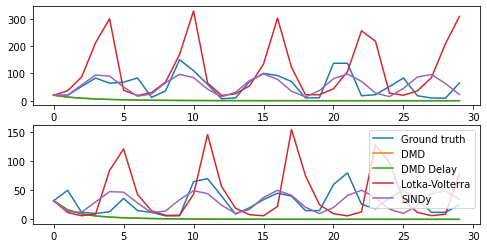

In [163]:
# Plot predictions, data side by side

fig, ax = plt.subplots(2,1, figsize=(8,4))
for i,elt in enumerate(data_list):
    ax[0].plot(elt[0,:], label=g_names[i])

for i,elt in enumerate(data_list):
    ax[1].plot(elt[1,:], label=g_names[i])

ax[1].legend()
plt.show()

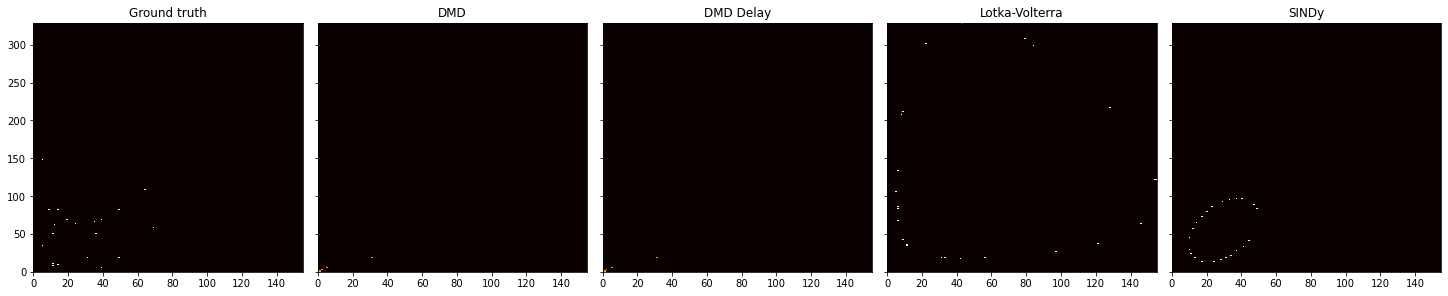

In [173]:
fig, ax = plt.subplots(1,5,figsize=(20,4), sharex=True, sharey=True, constrained_layout=True)

for i, elt in enumerate(gs):
    ax[i].pcolormesh(np.log(elt), cmap='hot')
    ax[i].set_title(g_names[i])

plt.show()


In [29]:
n = 4 # Polynomials of order n
d = 3

total_lib_fcns = 0
for n in np.arange(1, n + 1):
    for max_exp in range(1, n + 1):
        forms = get_forms(n, max_exp)

        for form in forms:
            if len(form) <= d:
                ct = get_count(form, d)
                total_lib_fcns += ct
                print(n, max_exp, form, ct)

print("Total: ", total_lib_fcns)

1 1 [1] 3.0
2 1 [1, 1] 3.0
2 2 [2] 3.0
3 1 [1, 1, 1] 1.0
3 2 [2, 1] 6.0
3 3 [3] 3.0
4 2 [2, 2] 3.0
4 2 [2, 1, 1] 3.0
4 3 [3, 1] 6.0
4 4 [4] 3.0
Total:  34.0


In [4]:
# Load Belousov-Zhabotinsky data
mat = loadmat('BZ.mat')

(351, 451, 1200)


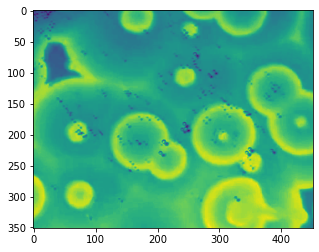

In [5]:
# Plot snapshots
bz = mat['BZ_tensor']
t_range = bz.shape[-1]
print(bz.shape)

for i in range(3):
    plt.imshow(bz[:,:,i])
plt.show()

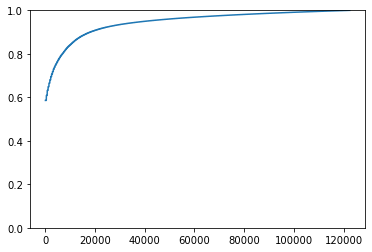

In [8]:
def rand_svd(x, r):
    '''
    Randomized Singular Value Decomposition.
    '''

    m, n = x.shape
    p = np.random.randn(n, r) # Random vectors
    z = x @ p # Random projections into col space of x
    q, r = np.linalg.qr(z) # Get orthonormal basis of col space of x
    y = q.T @ x # Project x down to reduced space
    uy, s, vt = svd(y)
    u = q @ uy # Project back up to high dim space

    return u, s, vt

r = 350

u, s, vt = rand_svd(bz_st, r)
s = np.diag(s)
cum_energy = np.cumsum(s / s.sum())
plt.plot(cum_energy)
plt.ylim(0,1)
plt.show()


In [45]:
print(bz_st.shape)
print(bz.shape)
print(cum_energy.shape)
print(u.shape, s.shape, vt[:r].shape)

(158301, 1200)
(351, 451, 1200)
(122500,)
(158301, 350) (350, 350) (350, 1200)


In [35]:
cum_energy[350]

0.9498609581950516

In [46]:
bz_approx = u @ s @ vt[:r]
bz_approx = bz_approx.reshape(351, 451, 1200)

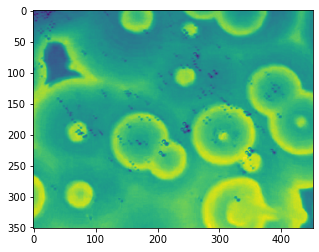

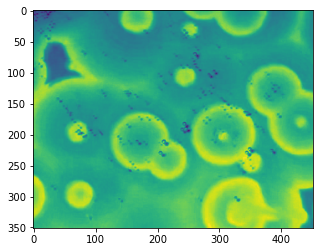

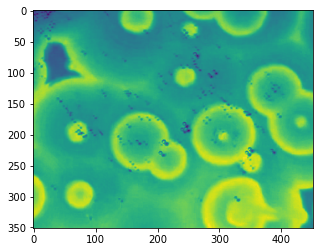

In [49]:
for i in range(3):
    plt.imshow(bz_approx[:,:,i])
    plt.show()

In [16]:
# Fit DMD model of BZ rxn

r= 350
mode = 'rand'
x0 = bz_st[:,0].reshape(-1,1)
k = t_range - 1
k = 200
save_dir = '/cnl/data/spate/Corn/'

dmd_bz = dmd()
print('Fitting')
dmd_bz.fit(bz_st, r=r, mode=mode)
print('Predicting')
x_hat_bz = dmd_bz.predict(x0, k=k)
print('Saving')
np.savetxt(save_dir + 'dmd_bz_rxn.csv', x_hat_bz, delimiter=',')

Fitting
Predicting
Saving


In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(6,36))

for i in range(k):
    ax[i,0].pcolormesh(bz[:,:,i])
    ax[i,1].pcolormesh(x_hat_bz[:,:,i])

plt.show()